import zipfile
with zipfile.ZipFile('custom.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

# Siamese Neural Network

Siamese neural network is a class of neural network architectures that contain two or more identical sub networks. identical here means they have the same configuration with the same parameters and weights. Parameter updating is mirrored across both sub networks.It is used find the similarity of the inputs by comparing its feature vectors.

For more details check this blog : https://innovationincubator.com/siamese-neural-network-with-code-example/

## Steps to create classifier using Siamese Neural Network 


1.   **Data Preprocessing**
2.   **Define the Siamese Network**
3.   **Feature Vector Extraction**
4.   **Similarity Score Calculation**
5.   **Defininf Loss Function**
6.   **Optimizer**
7.   **Testing using One-Shot Learnig**
8.   **Making Predictions**



Let's  go step wise 

## Import and Install all the necessary packages

In [50]:
# Import all the necessary Library 
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
from sklearn.model_selection import train_test_split
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import warnings
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (15,15)

In [51]:
path = './custom/full'

In [52]:
data = pd.DataFrame()

folders = os.listdir('./custom/full')
folders.sort()
folders = folders
for x in tqdm(range(0,len(folders),2)):
    for y in os.listdir(path + '/' + folders[x]):
        for z in os.listdir(path + '/' + folders[x]):
            if y != z:
                data = data.append([[str(folders[x]) + '/' + y, str(folders[x]) + '/' + z, 0]])
                
for x in tqdm(range(0,len(folders),2)):
    for y in os.listdir(path + '/' + folders[x]):
        for z in os.listdir(path + '/' + folders[x] + '_forg'):
            data = data.append([[str(folders[x]) + '/' + y, str(folders[x]) + '_forg' + '/' + z, 1]])

data.to_csv('./custom/data.csv',index=False)
data.head(10)

  0%|          | 0/119 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Additional Utility Functions 

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

### Statified Split

In [ ]:
data = pd.read_csv('./custom/data.csv').sample(frac=1)
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,[0,1]],data.iloc[:,[2]],test_size=0.1,stratify=data.iloc[:,2])

In [ ]:
pd.concat([X_train,y_train],axis=1).to_csv('./custom/train_data.csv',index=False)
pd.concat([X_test,y_test],axis=1).to_csv('./custom/test_data.csv',index=False)

In [ ]:
class Config():
    data_dir = "./model"
    train_batch_size = 32
    train_number_epochs = 100

## Load Dataset :

Datasets can be downloaded from this Link:  https://drive.google.com/file/d/1q03FLpaolm6Jq5vM0a_AEnjJoqjtxgP8/view?usp=sharing

**Copy the dataset directly to your drive and load it from there**

In [ ]:
data_dir = "./custom/full"
training_csv = "./custom/train_data.csv"
testing_csv = "./custom/test_data.csv"

### Preprocessing and Loading Dataset

We preprocessed all the images and loaded them as .npy files which is easy to transfer . You can follow your own preprocessing steps .


In [ ]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns =["image1","image2","label"]
        self.training_dir = training_dir    
        self.transform = transform

    def __getitem__(self,index):
        
        # getting the image path
        image1_path=os.path.join(self.training_dir,self.training_df.iat[index,0])
        image2_path=os.path.join(self.training_dir,self.training_df.iat[index,1])
        #print(image1_path,image2_path)
        
        
        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))
    
    def __len__(self):
        return len(self.training_df)

In [ ]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseNetworkDataset(training_csv,data_dir,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

In [ ]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
print(example_batch[0].size())
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Siamese Network Definition

In [ ]:
class SiameseNetwork1(nn.Module):
    def __init__(self):
        super(SiameseNetwork1, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(                                    # 1 x 105 x 105
            
            nn.Conv2d(1, 96, kernel_size=11,stride=1),                # 96 x 95 x 95
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),                                # 96 x 47 x 47
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),     # 256 x 47 x 47
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),                                # 256 x 23 x 23
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),    # 384 x 23 x 23
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),    # 256 x 23 x 23
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),                                # 256 x 11 x 11
            nn.Dropout2d(p=0.3),

        )
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2))
        
  
    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2


In [ ]:
class SiameseNetwork2(nn.Module):
    def __init__(self):
        super(SiameseNetwork2, self).__init__()
        self.cnn1 = nn.Sequential(              # 1 x 105 x 105
            nn.Conv2d(1, 20, kernel_size=5),    # 20 x 101 x 101
            nn.MaxPool2d(3, stride=2),          # 20 x 50 x 50
            nn.Conv2d(20, 50, kernel_size=5),   # 50 x 46 x 46
            nn.MaxPool2d(2, stride=2))          # 50 x 23 x 23
        self.fc1 = nn.Sequential(
            nn.Linear(50 * 23 * 23, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500,10),
            nn.Linear(10, 2))
        
    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [ ]:
class SiameseNetwork3(nn.Module):
    def __init__(self):
        super(SiameseNetwork3, self).__init__()                                # 1 x 105 x 105
        
        self.conv1 = nn.Conv2d(1, 48, kernel_size=(11, 11), stride=1)            # 48 x 95 x 95
        self.lrn1 = nn.LocalResponseNorm(48, alpha=1e-4, beta=0.75, k=2)         
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=2)                  # 48 x 47 x 47
        self.conv2 = nn.Conv2d(48, 128, kernel_size=(5, 5), stride=1, padding=2) # 128 x 47 x 47
        self.lrn2 = nn.LocalResponseNorm(128, alpha=1e-4, beta=0.75, k=2)        
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=2)                  # 128 x 23 x 23
        self.dropout1 = nn.Dropout(0.3)                                          
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=1, padding=1)# 256 x 23 x 23
        self.conv4 = nn.Conv2d(256, 96, kernel_size=(3, 3), stride=1, padding=1) # 96 x 23 x 23
        self.pool3 = nn.MaxPool2d(kernel_size=(3, 3), stride=2)                  # 96 x 11 x 11
        self.dropout2 = nn.Dropout(0.3)                                    
        self.fc1 = nn.Linear(96 * 11 * 11, 1024)                               
        self.dropout3 = nn.Dropout(0.5)                                      
        self.fc2 = nn.Linear(1024, 128)
        
    def forward_once(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.lrn1(x)
        x = self.pool1(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.lrn2(x)
        x = self.pool2(x)
        x = self.dropout1(x)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        x = self.pool3(x)
        x = self.dropout2(x)
        x = x.view(-1, 96 * 11 * 11)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout3(x)
        x = nn.functional.relu(self.fc2(x))
        return x

    def forward(self, x, y):
        f_x = self.forward_once(x)
        f_y = self.forward_once(y)
        return f_x, f_y

### Loss Function

In [95]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        #loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) + (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        #loss_contrastive = torch.sum(loss_contrastive) / 2.0 / output1.size()[0]
        return loss_contrastive

### Plot Loss

In [96]:
def plot_loss(train_loss):
    plt.plot(train_loss, label="train loss")
    plt.legend()

### Train the Model

In [97]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [98]:
# Check whether you have GPU is loaded or not
if torch.cuda.is_available():
    print('Yes')

Yes


In [114]:
def train(net,criterion,scheduler=None):
    counter = []
    loss_history = [] 
    iteration_number= 0
    
    for epoch in range(0,Config.train_number_epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            
            if i %100 == 0 :
                print("Epoch number {}\n Current loss {}\n Learning Rate {}\n".format(epoch,loss_contrastive.item(),scheduler.optimizer.param_groups[0]['lr']))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
        
        if scheduler!=None:
            scheduler.step()
    
    return net,loss_history

### Model 1 - Accuracy - 50

In [53]:
# Declare Siamese Network
net1 = SiameseNetwork1().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = optim.RMSprop(net1.parameters(), lr=0.00001, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.8)
#optimizer = torch.optim.SGD(net1.parameters(), lr=0.00001, momentum=0.8)

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Train the model
model1,loss_history1 = train(net1,criterion)
torch.save(model1.state_dict(), "./model/model1.pt")
print("Model Saved Successfully")

Epoch number 0
 Current loss 0.007746732793748379

Epoch number 0
 Current loss 0.004989439155906439

Epoch number 0
 Current loss 0.005183550529181957

Epoch number 0
 Current loss 0.005321804899722338

Epoch number 0
 Current loss 0.004775776527822018

Epoch number 0
 Current loss 0.0047976355999708176

Epoch number 0
 Current loss 0.003689951030537486

Epoch number 0
 Current loss 0.004905028268694878

Epoch number 0
 Current loss 0.004258079454302788

Epoch number 0
 Current loss 0.004683276172727346

Epoch number 0
 Current loss 0.004218813963234425

Epoch number 0
 Current loss 0.003991723991930485

Epoch number 0
 Current loss 0.004769997671246529

Epoch number 0
 Current loss 0.004503864794969559

Epoch number 0
 Current loss 0.004791460931301117

Epoch number 0
 Current loss 0.005162735469639301

Epoch number 0
 Current loss 0.004952081013470888

Epoch number 0
 Current loss 0.005160066299140453

Epoch number 0
 Current loss 0.004751875065267086

Epoch number 0
 Current loss 0

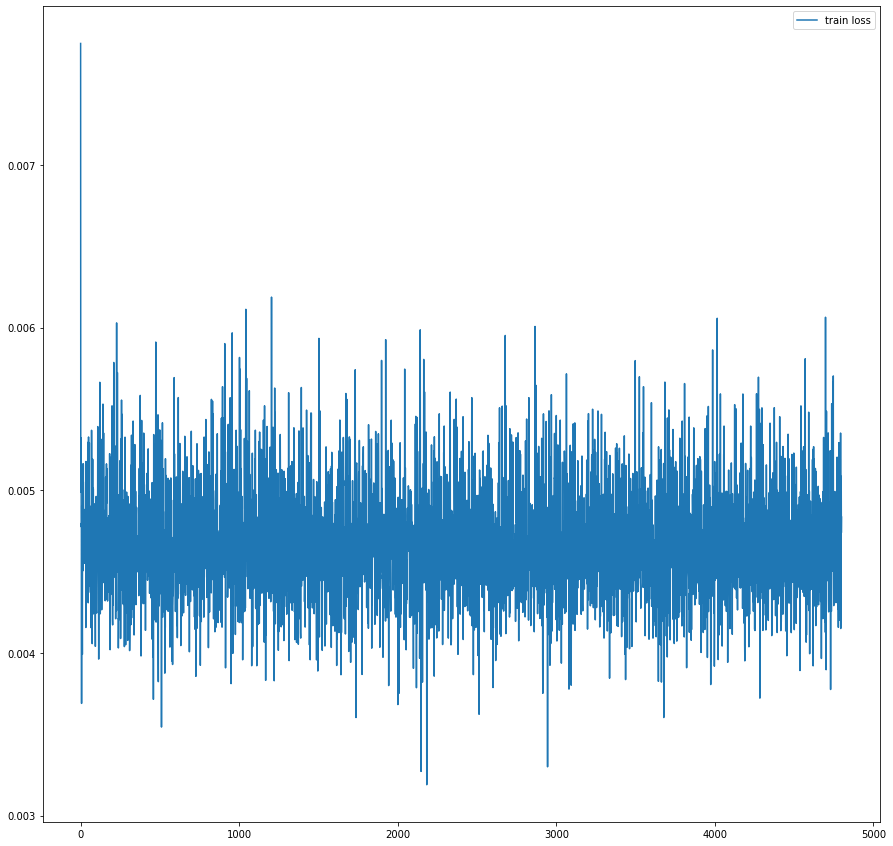

In [55]:
plot_loss(loss_history1)

### Model 2 - Accuracy - 75

In [115]:
# Declare Siamese Network
net2 = SiameseNetwork2().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = optim.RMSprop(net2.parameters(), lr=0.00001, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.8)
#scheduler = optim.lr_scheduler.StepLR(optimizer,step_size = 20, gamma = 0.1)
#optimizer = torch.optim.SGD(net2.parameters(), lr=0.00001, momentum=0.8)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Train the model
model2,loss_history2 = train(net2,criterion,scheduler)
torch.save(model2.state_dict(), "./model/model2.pt")
print("Model Saved Successfully")

Epoch number 0
 Current loss 0.4945616126060486
 Learning Rate 1.0000000000000005e-09

Epoch number 0
 Current loss 0.2857285439968109
 Learning Rate 1.0000000000000005e-09

Epoch number 0
 Current loss 0.32647576928138733
 Learning Rate 1.0000000000000005e-09

Epoch number 0
 Current loss 0.30302590131759644
 Learning Rate 1.0000000000000005e-09

Epoch number 0
 Current loss 0.2704506516456604
 Learning Rate 1.0000000000000005e-09

Epoch number 0
 Current loss 0.3211541771888733
 Learning Rate 1.0000000000000005e-09

Epoch number 0
 Current loss 0.31251639127731323
 Learning Rate 1.0000000000000005e-09

Epoch number 0
 Current loss 0.2862277626991272
 Learning Rate 1.0000000000000005e-09

Epoch number 0
 Current loss 0.30426543951034546
 Learning Rate 1.0000000000000005e-09

Epoch number 0
 Current loss 0.2964715361595154
 Learning Rate 1.0000000000000005e-09

Epoch number 0
 Current loss 0.26712268590927124
 Learning Rate 1.0000000000000005e-09

Epoch number 0
 Current loss 0.3490126

In [ ]:
plot_loss(loss_history2)

### Model 3 - Accuracy - 49

In [ ]:
# Declare Siamese Network
net3 = SiameseNetwork3().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = optim.RMSprop(net3.parameters(), lr=0.00001, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.8)
#optimizer = torch.optim.SGD(net3.parameters(), lr=0.00001, momentum=0.8)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Train the model
model3,loss_history3 = train(net3,criterion)
torch.save(model3.state_dict(), "./model/model3.pt")
print("Model Saved Successfully")

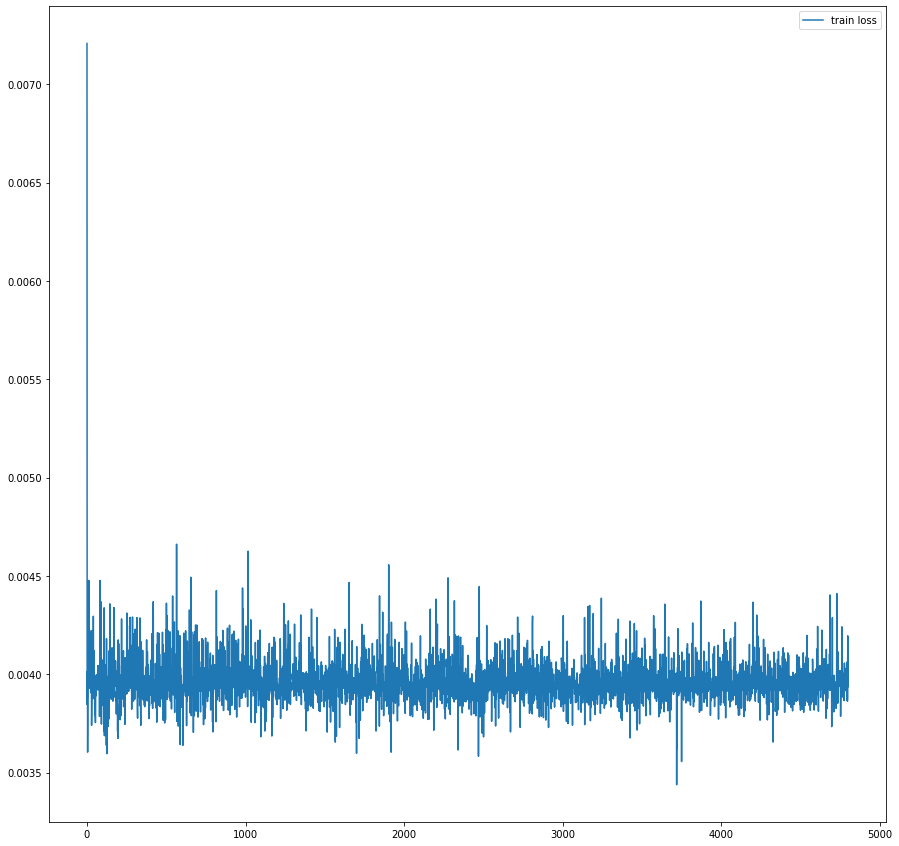

In [61]:
plot_loss(loss_history3)

### Testing

In [111]:
# Load the test dataset
test_dataset = SiameseNetworkDataset(training_csv=testing_csv,training_dir=data_dir,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)

### Prediction Model 1

In [63]:
# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork1().to(device)
model.load_state_dict(torch.load("./model/model1.pt"))

<All keys matched successfully>

In [64]:
# Print the sample outputs to view its dissimilarity
pos = 0
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
    x0, x1 , label = data
    concatenated = torch.cat((x0,x1),0)
    output1,output2 = model(x0.to(device),x1.to(device))
    eucledian_distance = F.pairwise_distance(output1, output2)
    
    if eucledian_distance.item() <= 0.4:
        pred = 0.0
    else:
        pred = 1.0
        
    if pred == label.item():
        pos+=1
        
    if label==list_0:
        label="Orginial"
    else:
        label="Forged"
    #imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
    counter=counter+1
        
accuracy = pos/len(test_dataloader)
print('Accuracy : ',accuracy)

Accuracy :  0.5059237536656892


### Prediction Model 2

In [112]:
# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork2().to(device)
model.load_state_dict(torch.load("./model/model2.pt"))

<All keys matched successfully>

In [113]:
# Print the sample outputs to view its dissimilarity
pos = 0
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
    x0, x1 , label = data
    concatenated = torch.cat((x0,x1),0)
    output1,output2 = model(x0.to(device),x1.to(device))
    eucledian_distance = F.pairwise_distance(output1, output2)
    
    if eucledian_distance.item() <= 0.4:
        pred = 0.0
    else:
        pred = 1.0
        
    if pred == label.item():
        pos+=1
        
    if label==list_0:
        label="Orginial"
    else:
        label="Forged"
    #imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
    counter=counter+1
        
accuracy = pos/len(test_dataloader)
print('Accuracy : ',accuracy)

Accuracy :  0.5926099706744868


### Prediction Model 3

In [67]:
# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork3().to(device)
model.load_state_dict(torch.load("./model/model3.pt"))

<All keys matched successfully>

In [68]:
# Print the sample outputs to view its dissimilarity
pos = 0
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
    x0, x1 , label = data
    concatenated = torch.cat((x0,x1),0)
    output1,output2 = model(x0.to(device),x1.to(device))
    eucledian_distance = F.pairwise_distance(output1, output2)
    
    if eucledian_distance.item() <= 0.4:
        pred = 0.0
    else:
        pred = 1.0
        
    if pred == label.item():
        pos+=1
        
    if label==list_0:
        label="Orginial"
    else:
        label="Forged"
    #imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
    counter=counter+1
        
accuracy = pos/len(test_dataloader)
print('Accuracy : ',accuracy)

Accuracy :  0.49595307917888565


## Final Touch 

Thats it guys ! I am limited by time , computational power and knowledge .to get standard accuracy . But anyway this is the working code of Siamese Neural Network and you can try it for your own applications and dataset.

Paper Reference: https://arxiv.org/pdf/1707.02131.pdf

Thanks to Gupta Blog : https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e